<a href="https://colab.research.google.com/github/Pulathanuja006/FMML_COURSE_ASSIGNMENT/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:


# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-10 15:02:40--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.109, 13.225.4.25, 13.225.4.31, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   263MB/s    in 0.2s    

2024-05-10 15:02:40 (263 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


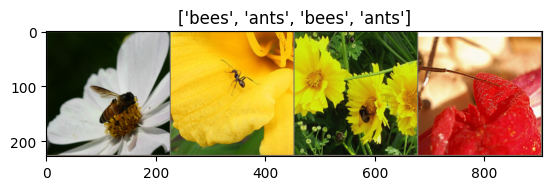

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6317 Acc: 0.7336

Epoch 1/4
----------
Loss: 0.5677 Acc: 0.7787

Epoch 2/4
----------
Loss: 0.5733 Acc: 0.7787

Epoch 3/4
----------
Loss: 0.6016 Acc: 0.7910

Epoch 4/4
----------
Loss: 0.4121 Acc: 0.8484



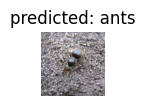

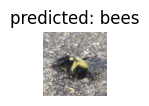

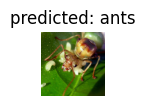

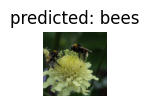

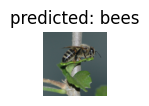

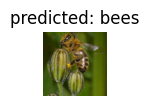

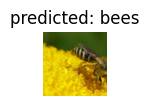

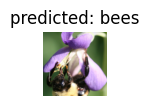

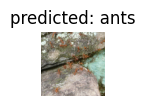

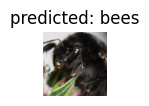

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


1)Data augmentation techniques like resizing, cropping, flipping, rotating, and adjusting brightness or contrast are commonly used in training data for several reasons:

Increased Variation: By applying different augmentation techniques, you can increase the diversity of your training dataset. This helps the model generalize better to unseen data and reduces the risk of overfitting. For example, flipping an image horizontally or vertically creates a mirrored version, effectively doubling the size of the dataset.
Robustness to Variations: Data augmentation helps the model become more robust to variations in the input data. For instance, if your model needs to classify objects in images taken under different lighting conditions, augmenting the data with brightness adjustments can help the model learn to recognize objects under various lighting conditions.
Translation Invariance: Techniques like cropping and resizing can help the model become invariant to translations and scale changes in the input data. This means that the model can still recognize objects even if they appear in different positions or sizes within the image.
Regularization: Data augmentation acts as a form of regularization by adding noise to the training data. This can help prevent overfitting by discouraging the model from relying too heavily on specific features or patterns in the training data.
Improved Performance: In many cases, models trained with augmented data tend to perform better than models trained with the original data alone. This is because the augmented data provides more diverse examples for the model to learn from, leading to better generalization on unseen data.
Overall, data augmentation is a powerful technique for improving the performance and robustness of machine learning models, especially in scenarios where the training data is limited or the input data exhibits various forms of variability.








2)If you don't use a pretrained ResNet model and instead train the model from scratch (by setting pretrained=False), the performance might be adversely affected, especially if you have a limited training dataset. Here's why:

Feature Learning: Pretrained models, such as ResNet, are trained on large datasets (e.g., ImageNet) and have learned to extract useful features from images. When you use a pretrained model, these learned features are transferred to your task, which can significantly boost performance, especially when you have a small training dataset. Without using a pretrained model, your network has to learn these features from scratch, which can be challenging and might require a larger dataset.
Generalization: Pretrained models have already learned generic features from a diverse range of images, which helps them generalize well to new tasks or datasets. Training from scratch might lead to poorer generalization, especially if your dataset is limited or doesn't cover the same range of variations seen in the ImageNet dataset.
Computational Resources: Training a deep neural network from scratch can be computationally intensive and time-consuming, especially if you don't have access to powerful hardware like GPUs. Using a pretrained model allows you to leverage the prelearned features without the need for extensive training.
Risk of Overfitting: Training a deep neural network from scratch on a small dataset increases the risk of overfitting, where the model learns to memorize the training examples rather than generalizing well to new data. Pretrained models, by virtue of their prelearned features, are less prone to overfitting, especially when



3)If the ResNet model was pretrained on a dataset significantly different from the ants vs. bees data, you may not necessarily get good performance when using this pretrained model directly. Here's why:

Domain Shift: If the pretrained dataset is significantly different from the ants vs. bees dataset in terms of content, style, or distribution, there may be a domain shift. This means that the learned features from the pretrained model may not generalize well to the new dataset. For example, if the pretrained model was trained on medical images and the ants vs. bees dataset consists of natural images, the features learned by the pretrained model may not be directly applicable to the new dataset.
Task Specificity: Even if the pretrained model was trained on a dataset with similar content but for a different task, the features learned by the model may not be optimal for the ants vs. bees classification task. Pretrained models are typically trained for generic feature extraction tasks (e.g., object recognition in ImageNet), and these features may not capture the specific characteristics relevant to distinguishing between ants and bees.
Fine-tuning or Transfer Learning: In cases where the pretrained model is not directly applicable to the new dataset, fine-tuning or transfer learning techniques can be employed. This involves taking the pretrained model and adapting it to the new dataset by updating its weights during training on the new data. This process allows the model to learn dataset-specific features while still benefiting from the general knowledge captured during pretraining.
In summary, while using a pretrained model can provide a good starting point for transfer learning, the performance may be limited if the pretrained model is not well-suited to the new dataset. It's important to consider factors such as domain similarity and task specificity when deciding whether to use a pretrained model and how to adapt it to the new dataset.






